In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests

In [51]:
url = 'https://api.llama.fi/v2/chains'
response = requests.get(url)
if response.status_code == 200: # data was fetched successfully
    data = response.json()
    df = pd.DataFrame(data)
else:
    raise Exception('Error fetching data from DeFiLlama API')

dex_all_chains_url = "https://api.llama.fi/overview/dexs?excludeTotalDataChart=true&excludeTotalDataChartBreakdown=true&dataType=dailyVolume"
dex_all_chains_response = requests.get(dex_all_chains_url)

dex_all_chains_data = dex_all_chains_response.json()
dex_all_chains = set(dex_all_chains_data.get('allChains', []))


fees_all_chains_url = "https://api.llama.fi/overview/fees?excludeTotalDataChart=true&excludeTotalDataChartBreakdown=true&dataType=dailyFees"
fees_all_chains_response = requests.get(fees_all_chains_url)

fees_all_chains_data = fees_all_chains_response.json()
fees_all_chains = set(fees_all_chains_data.get('allChains', []))

common_chains = dex_all_chains.intersection(fees_all_chains) # get the common chains between the two sets

df = df[['name', 'tvl']]
name_list = df[df['name'].isin(common_chains)]

# Sort the data to get the top 10 chains by TVL
name_list = name_list.sort_values(by='tvl', ascending=False).head(11)
print(name_list)


         name           tvl
15   Ethereum  7.689544e+10
47     Solana  9.401312e+09
92       Tron  9.025371e+09
8         BSC  5.820793e+09
12       Base  3.923212e+09
54    Bitcoin  3.588940e+09
17   Arbitrum  3.340990e+09
95        Sui  1.747100e+09
16  Avalanche  1.588138e+09
58      Aptos  1.263606e+09
18    Polygon  1.175651e+09


In [52]:
# print(plt.style.available)
def plot_chains(data_dict, metric, mode='combined', selected_chain=None):
    """
    plot data for different chains.(combnied or single)

    Parameters:
    data_dict (dict): dict of dataframes, key is chain name, value is dataframe.
    metric (str): metric type（'fee'、'tvl'、'volume'）.
    mode (str): 'combined' means plot data for same metric，'single' means plot data for different chains, different metric.
    selected_chain (str): used under only 'single' mode, specify the chain name.
    """
    if mode == 'combined':
        plt.figure(figsize=(14, 7))
        
        for chain_name, df in data_dict.items():
            plt.plot(df['date'], df['value'], label=chain_name)

        plt.xlabel('Date')
        plt.ylabel(f'{metric.capitalize()} Value')
        plt.title(f'{metric.capitalize()} Over Time for Different Chains')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend(loc='best')
        plt.tight_layout()
        
        output_folder = './results/combined_charts'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        # save the plot
        
        plt.savefig(os.path.join(output_folder,f'combined_{metric}_chart.png'))
        print(f"combined {metric} has been saved as combined_{metric}_chart.png")
        plt.show()
        plt.close()
        
    elif mode == 'single':
        if selected_chain is None:
            raise ValueError("In 'single' mode, you must specify 'selected_chain'.")
        
        if selected_chain not in data_dict:
            raise ValueError(f"Chain '{selected_chain}' not found in data.")

        df = data_dict[selected_chain]

        plt.style.use('seaborn-v0_8')

        plt.figure(figsize=(14, 7))

        plt.plot(df['date'], df['value'], color='royalblue', linewidth=2.5, label=f'{selected_chain} {metric}')
    
        plt.xlabel('Date', fontsize=14, fontweight='bold')
        plt.ylabel(f'{metric.capitalize()} Value', fontsize=14, fontweight='bold')
        plt.title(f'{selected_chain} {metric.capitalize()} Over Time', fontsize=16, fontweight='bold')
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(visible=True, linestyle='--', linewidth=0.5)
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()

        output_folder = './results/output_single_charts'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        plt.savefig(os.path.join(output_folder, f'{selected_chain}_{metric}_single_chart.png'))
        print(f"{selected_chain} {metric} has been saved as {selected_chain}_{metric}_single_chart.png")
        plt.show()
        plt.close()


In [53]:
# def plot_chain_zscore(data_dict_all, chain_name, metric, window_size=30, threshold=2):
#     """
#     compute Z score for a single metric of a single chain and plot the anomaly detection chart.

#     Parameters:
#     - data_dict_all (dict): all data of 150 days.
#     - chain_name (str): name of the chain
#     - metric (str): metric type（'fee'、'tvl'、'volume'）.
#     - window_size (int): size of the rolling window, default 30.
#     - threshold (int): z score threshold, default 2.
#     """
#     df = data_dict_all[metric][chain_name].copy()

#     df['rolling_mean'] = df['value'].rolling(window=window_size).mean()
#     df['rolling_std'] = df['value'].rolling(window=window_size).std()

#     df['z_score'] = (df['value'] - df['rolling_mean']) / df['rolling_std']

#     df['is_anomaly'] = df['z_score'].abs() > threshold

#     df_plot = df.tail(120)

#     plt.style.use('seaborn-v0_8')
#     plt.figure(figsize=(14, 7))

#     plt.plot(df_plot['date'], df_plot['value'], color='royalblue', linewidth=2.5, label='Value')

#     plt.plot(df_plot['date'], df_plot['rolling_mean'], color='orange', linestyle='--', linewidth=2, label=f'{window_size}-day Rolling Mean')

#     anomalies = df_plot[df_plot['is_anomaly']]
#     plt.scatter(anomalies['date'], anomalies['value'], color='red', s=60, edgecolor='black', label='Anomalies', zorder=5)

#     plt.xlabel('Date', fontsize=14, fontweight='bold')
#     plt.ylabel(f'{metric.capitalize()} Value', fontsize=14, fontweight='bold')
#     plt.title(f'{chain_name} {metric.capitalize()} Over Time with Z-Score Anomalies (Last 120 Days)', fontsize=18, fontweight='bold')
#     plt.xticks(rotation=45, fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.grid(visible=True, linestyle='--', linewidth=0.5)
#     plt.legend(loc='best', fontsize=12)
#     plt.tight_layout()
    
#     output_folder = './results/z_score_charts'
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
        
#     plt.savefig(os.path.join(output_folder, f'{selected_chain}_{metric}_Z.png'))
#     print(f"{selected_chain} {metric} has been saved {selected_chain}_{metric}_Z.png")
#     plt.show()
#     plt.close()

In [54]:
def plot_chain_zscore(data_dict_all, chain_name, metric, window_size=30, threshold=2, include_price=False):
    """
    Compute Z score for a single metric of a single chain and plot the anomaly detection chart.

    Parameters:
    - data_dict_all (dict): all data of 150 days.
    - chain_name (str): name of the chain
    - metric (str): metric type ('fee', 'tvl', 'volume').
    - window_size (int): size of the rolling window, default 30.
    - threshold (int): z score threshold, default 2.
    - include_price (bool): whether to include price data in the plot, default False.
    """
    
    df = data_dict_all[metric][chain_name].copy()

    df['rolling_mean'] = df['value'].rolling(window=window_size).mean()
    df['rolling_std'] = df['value'].rolling(window=window_size).std()
    df['Z_score'] = (df['value'] - df['rolling_mean']) / df['rolling_std']
    df['is_anomaly'] = df['Z_score'].abs() > threshold

    df_plot = df.tail(120)

    plt.style.use('seaborn-v0_8')
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(df_plot['date'], df_plot['value'], color='royalblue', linewidth=2.5, label='Value')
    ax1.plot(df_plot['date'], df_plot['rolling_mean'], color='orange', linestyle='--', linewidth=2, label=f'{window_size}-day Rolling Mean')

    anomalies = df_plot[df_plot['is_anomaly']]
    ax1.scatter(anomalies['date'], anomalies['value'], color='red', s=60, edgecolor='black', label='Anomalies', zorder=5)

    ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax1.set_ylabel(f'{metric.capitalize()} Value', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', rotation=45, labelsize=12)
    ax1.grid(visible=True, linestyle='--', linewidth=0.5)
    ax1.legend(loc='upper left', fontsize=12)

    if include_price and 'price' in data_dict_all:
        ax2 = ax1.twinx()
        price_df = data_dict_all['price'][chain_name].tail(120)
        ax2.plot(price_df['date'], price_df['value'], color='green', linestyle='-', linewidth=2, label='Price')
        ax2.set_ylabel('Price Value', fontsize=14, fontweight='bold', color='green')
        ax2.tick_params(axis='y', labelsize=12, colors='green')
        ax2.legend(loc='upper right', fontsize=12)

    plt.title(f'{chain_name} {metric.capitalize()} Over Time with Z-Score Anomalies (Last 120 Days)', fontsize=18, fontweight='bold')
    plt.tight_layout()


    output_folder = './results/z_score_charts'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # plt.savefig(os.path.join(output_folder, f'{selected_chain}_{metric}_Z.png'))
    # print(f"{selected_chain} {metric} has been saved ({selected_chain}_{metric}_Z.png)")
    plt.show()
    plt.close()

In [55]:
def plot_chain_with_coin(data_dict_all, chain_name, metric, window_size=30, threshold=2, include_price=False):
    """
    Compute Z score for a single metric of a single chain and plot the anomaly detection chart.

    Parameters:
    - data_dict_all (dict): all data of 150 days.
    - chain_name (str): name of the chain
    - metric (str): metric type ('fee', 'tvl', 'volume').
    - window_size (int): size of the rolling window, default 30.
    - threshold (int): z score threshold, default 2.
    - include_price (bool): whether to include price data in the plot, default False.
    """
    
    df = data_dict_all[metric][chain_name].copy()

    df['rolling_mean'] = df['value'].rolling(window=window_size).mean()
    df['rolling_std'] = df['value'].rolling(window=window_size).std()
    df['Z_score'] = (df['value'] - df['rolling_mean']) / df['rolling_std']
    df['is_anomaly'] = df['Z_score'].abs() > threshold

    df_plot = df.tail(120)

    plt.style.use('seaborn-v0_8')
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(df_plot['date'], df_plot['value'], color='royalblue', linewidth=2.5, label='Value')
    ax1.plot(df_plot['date'], df_plot['rolling_mean'], color='orange', linestyle='--', linewidth=2, label=f'{window_size}-day Rolling Mean')

    anomalies = df_plot[df_plot['is_anomaly']]
    ax1.scatter(anomalies['date'], anomalies['value'], color='red', s=60, edgecolor='black', label='Anomalies', zorder=5)

    ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax1.set_ylabel(f'{metric.capitalize()} Value', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', rotation=45, labelsize=12)
    ax1.grid(visible=True, linestyle='--', linewidth=0.5)
    ax1.legend(loc='upper left', fontsize=12)

    if include_price and 'price' in data_dict_all and 'tvl' in data_dict_all:
        ax2 = ax1.twinx()
        price_df = data_dict_all['price'][chain_name].copy().tail(120)
        tvl_df = data_dict_all['tvl'][chain_name].copy().tail(120)
        merged_df = pd.merge(tvl_df, price_df, on='date', suffixes=('_tvl', '_price'))

        merged_df['tvl_price_ratio'] = merged_df['value_tvl'] / merged_df['value_price']

        print(merged_df[['date', 'tvl_price_ratio']])
        ax2.plot(merged_df['date'], merged_df['tvl_price_ratio'], color='green', linestyle='-', linewidth=2, label='coin')
        ax2.set_ylabel('TVL/Price', fontsize=14, fontweight='bold', color='green')
        ax2.tick_params(axis='y', labelsize=12, colors='green')
        ax2.legend(loc='upper right', fontsize=12)

    plt.title(f'{chain_name} {metric.capitalize()} Over Time with Z-Score Anomalies (Last 120 Days)', fontsize=18, fontweight='bold')
    plt.tight_layout()

    output_folder = './results/z_score_charts'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    plt.savefig(os.path.join(output_folder, f'{chain_name}_tvl_coin.png'))
    print(f"{chain_name} {metric} has been saved ({chain_name}_tvl_coin.png)")
    plt.show()
    plt.close()


          date  tvl_price_ratio
0   2024-08-09     1.915390e+07
1   2024-08-10     1.894895e+07
2   2024-08-11     1.953079e+07
3   2024-08-12     1.778134e+07
4   2024-08-13     1.803403e+07
..         ...              ...
115 2024-12-02     1.921324e+07
116 2024-12-03     1.967955e+07
117 2024-12-04     1.921185e+07
118 2024-12-05     2.040168e+07
119 2024-12-06     1.966595e+07

[120 rows x 2 columns]
Ethereum tvl has been saved (Ethereum_tvl_coin.png)


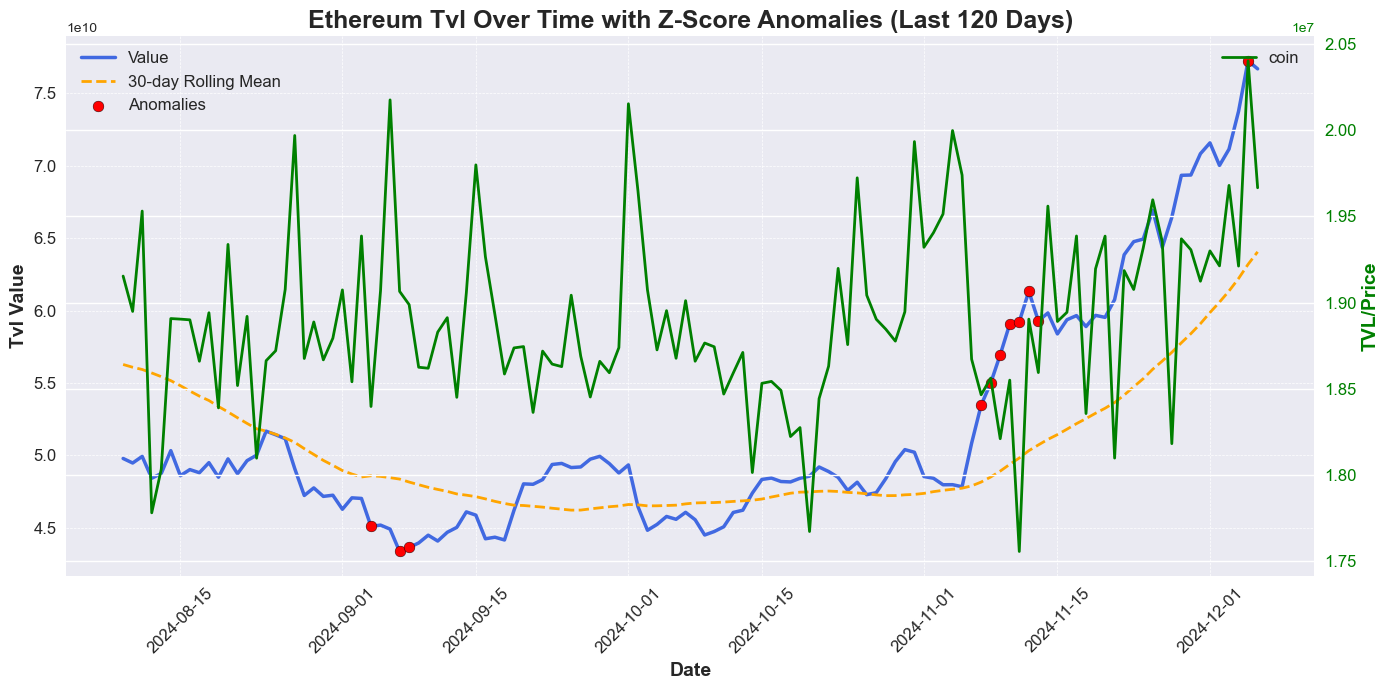

          date  tvl_price_ratio
0   2024-08-09     3.110802e+07
1   2024-08-10     3.109843e+07
2   2024-08-11     3.418105e+07
3   2024-08-12     3.171487e+07
4   2024-08-13     3.147606e+07
..         ...              ...
115 2024-12-02     3.890359e+07
116 2024-12-03     3.770186e+07
117 2024-12-04     4.000771e+07
118 2024-12-05     3.950223e+07
119 2024-12-06     3.967914e+07

[120 rows x 2 columns]
Solana tvl has been saved (Solana_tvl_coin.png)


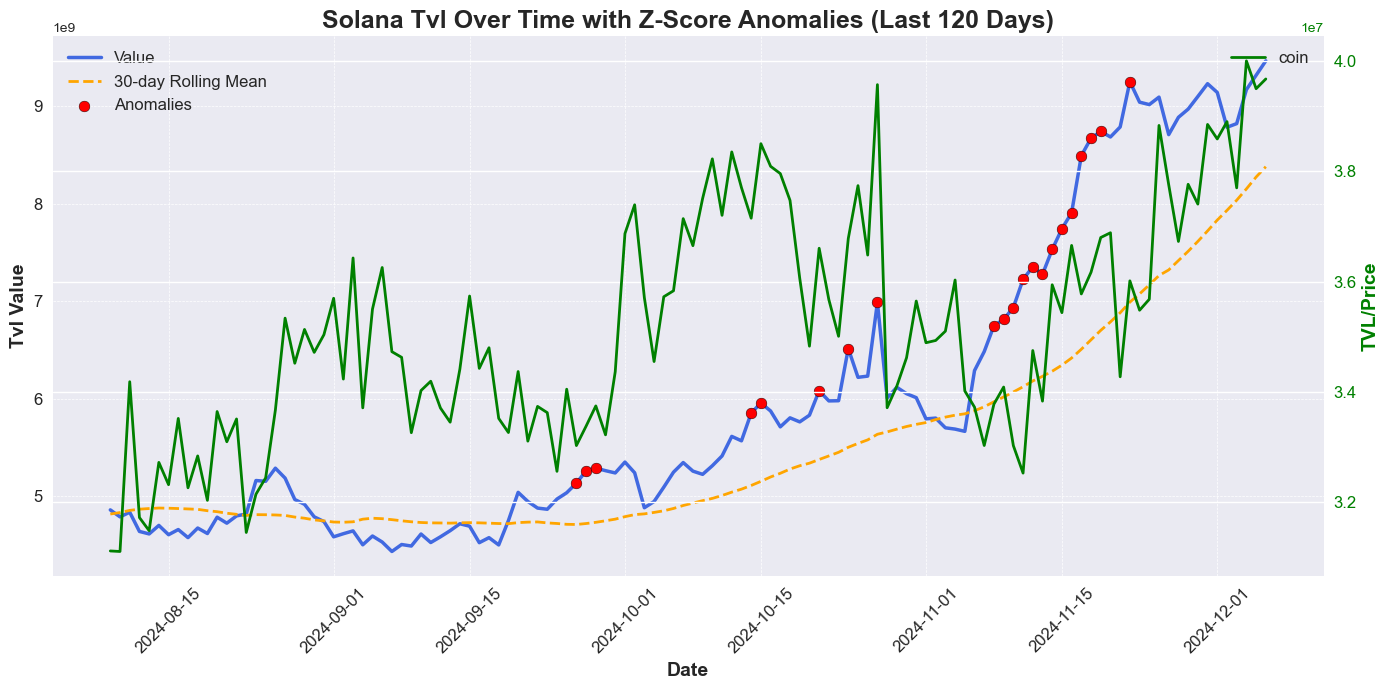

          date  tvl_price_ratio
0   2024-08-09      1028.358240
1   2024-08-10      1077.008971
2   2024-08-11      1091.732041
3   2024-08-12      1084.764999
4   2024-08-13      1105.819008
..         ...              ...
115 2024-12-02       532.434899
116 2024-12-03       123.702212
117 2024-12-04       292.993974
118 2024-12-05       248.858173
119 2024-12-06       227.180896

[120 rows x 2 columns]
Tron tvl has been saved (Tron_tvl_coin.png)


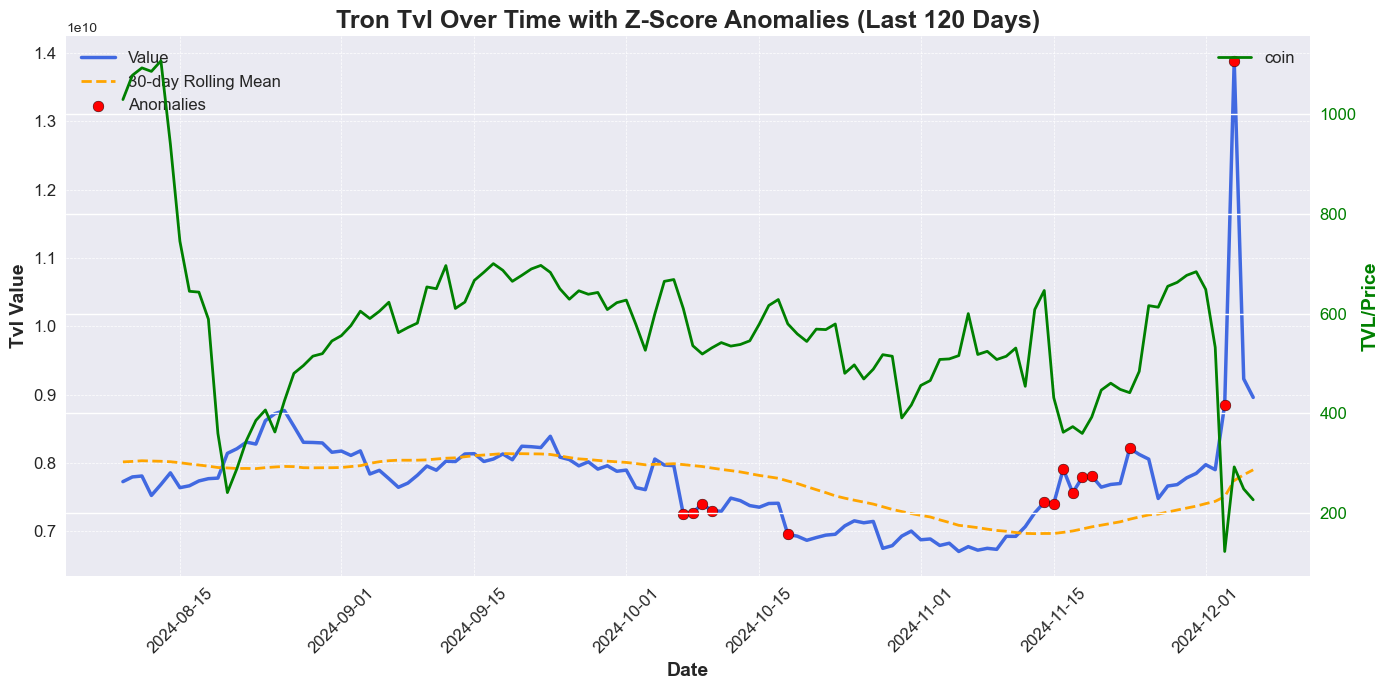

          date  tvl_price_ratio
0   2024-08-09     8.457576e+06
1   2024-08-10     8.217010e+06
2   2024-08-11     8.733252e+06
3   2024-08-12     8.176040e+06
4   2024-08-13     8.217652e+06
..         ...              ...
115 2024-12-02     8.273851e+06
116 2024-12-03     7.419960e+06
117 2024-12-04     8.097914e+06
118 2024-12-05     8.216547e+06
119 2024-12-06     8.011105e+06

[120 rows x 2 columns]
BSC tvl has been saved (BSC_tvl_coin.png)


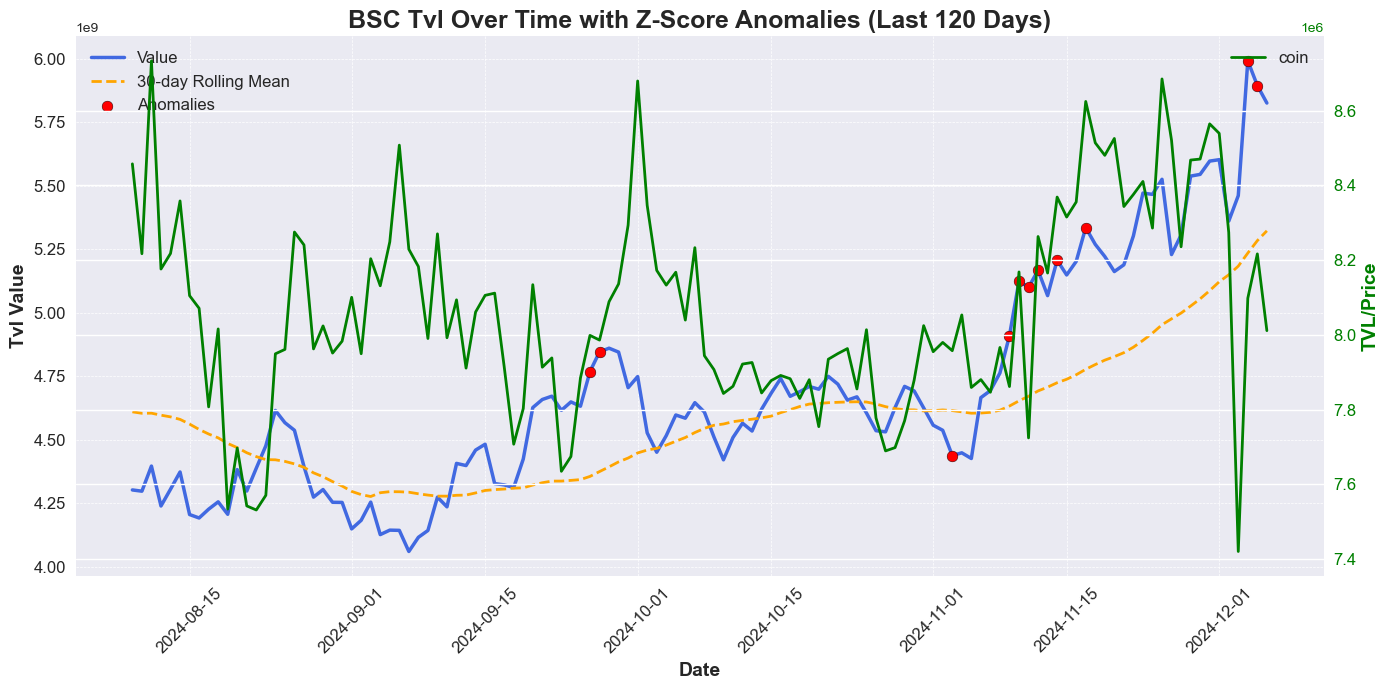

          date  tvl_price_ratio
0   2024-08-09     10575.262887
1   2024-08-10     10595.275831
2   2024-08-11     10981.956119
3   2024-08-12     13912.531791
4   2024-08-13     13409.039659
..         ...              ...
115 2024-12-02     37055.629046
116 2024-12-03     36465.846779
117 2024-12-04     36102.494239
118 2024-12-05     38819.492388
119 2024-12-06     36533.902420

[120 rows x 2 columns]
Bitcoin tvl has been saved (Bitcoin_tvl_coin.png)


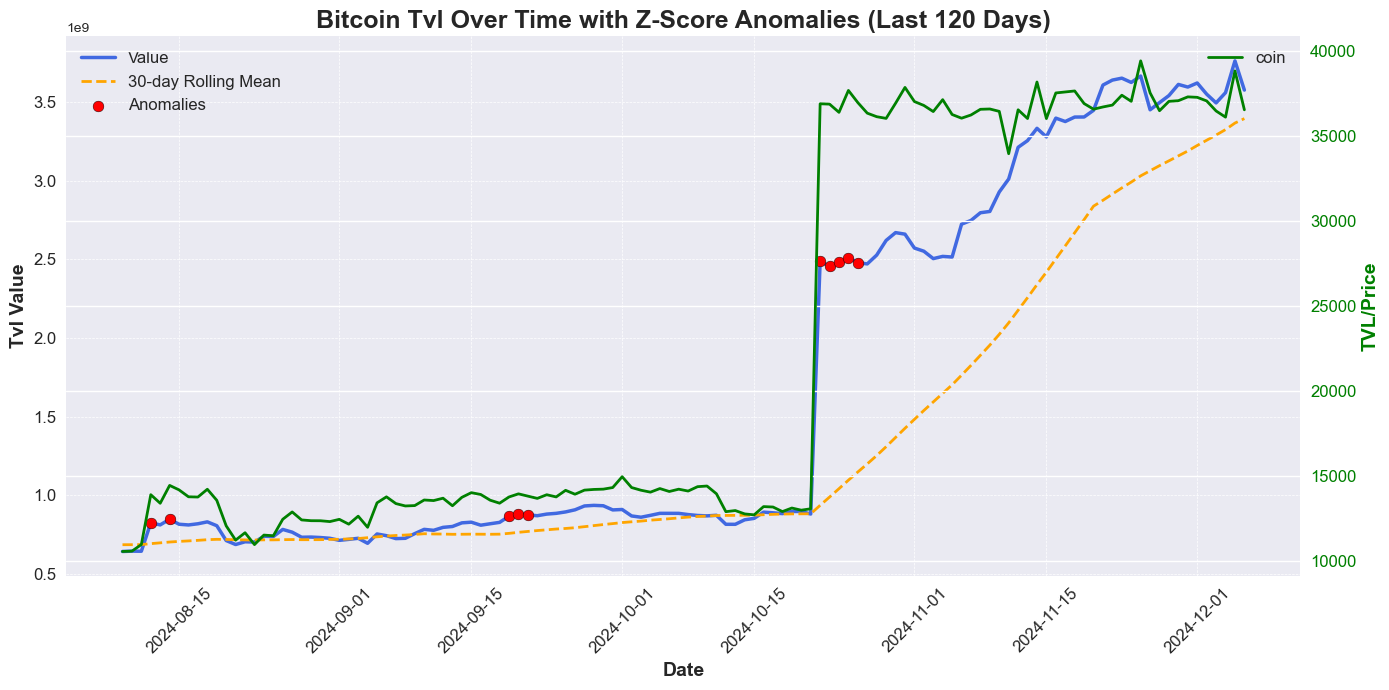

          date  tvl_price_ratio
0   2024-08-09     4.730975e+09
1   2024-08-10     4.678650e+09
2   2024-08-11     4.922898e+09
3   2024-08-12     4.525808e+09
4   2024-08-13     4.633123e+09
..         ...              ...
115 2024-12-02     3.031307e+09
116 2024-12-03     3.013999e+09
117 2024-12-04     2.852995e+09
118 2024-12-05     3.058831e+09
119 2024-12-06     2.870338e+09

[120 rows x 2 columns]
Arbitrum tvl has been saved (Arbitrum_tvl_coin.png)


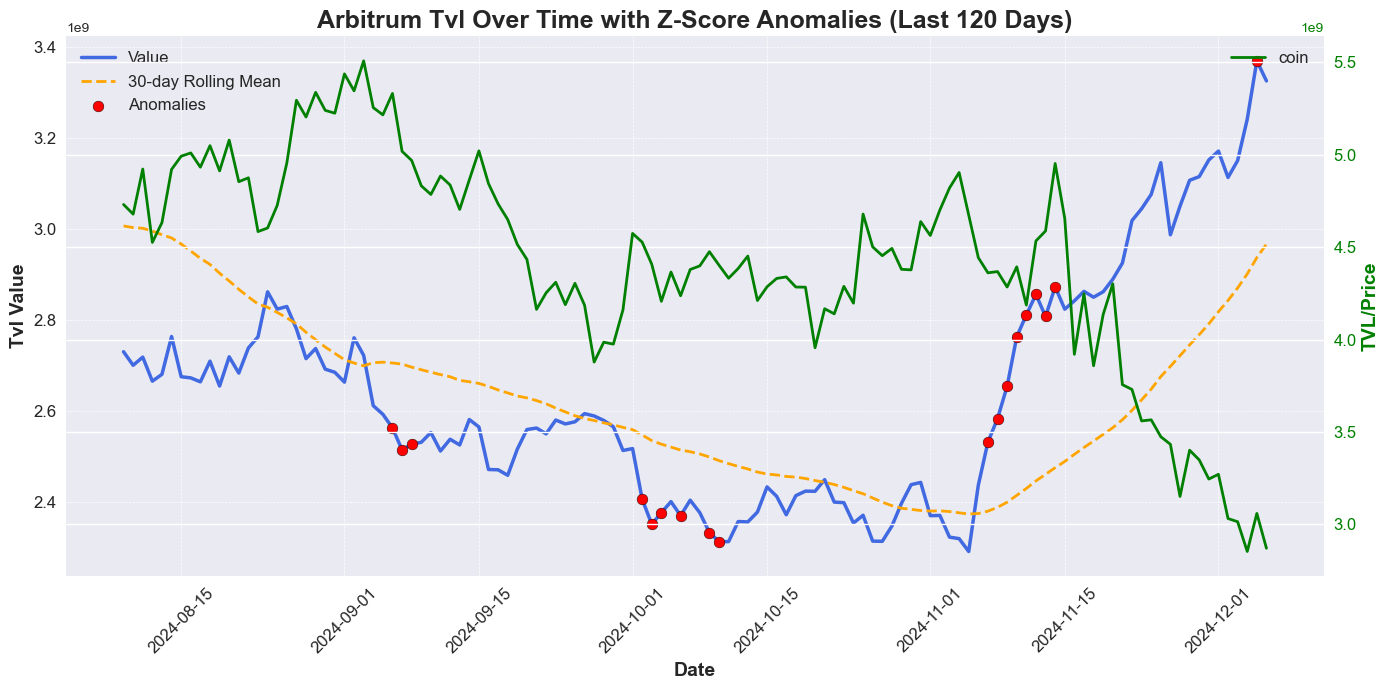

          date  tvl_price_ratio
0   2024-08-09     5.520081e+08
1   2024-08-10     5.532546e+08
2   2024-08-11     5.970583e+08
3   2024-08-12     5.470858e+08
4   2024-08-13     6.168068e+08
..         ...              ...
114 2024-12-01     4.291465e+08
115 2024-12-02     4.197371e+08
116 2024-12-03     4.197733e+08
117 2024-12-04     4.294111e+08
118 2024-12-05     4.296330e+08

[119 rows x 2 columns]
Sui tvl has been saved (Sui_tvl_coin.png)


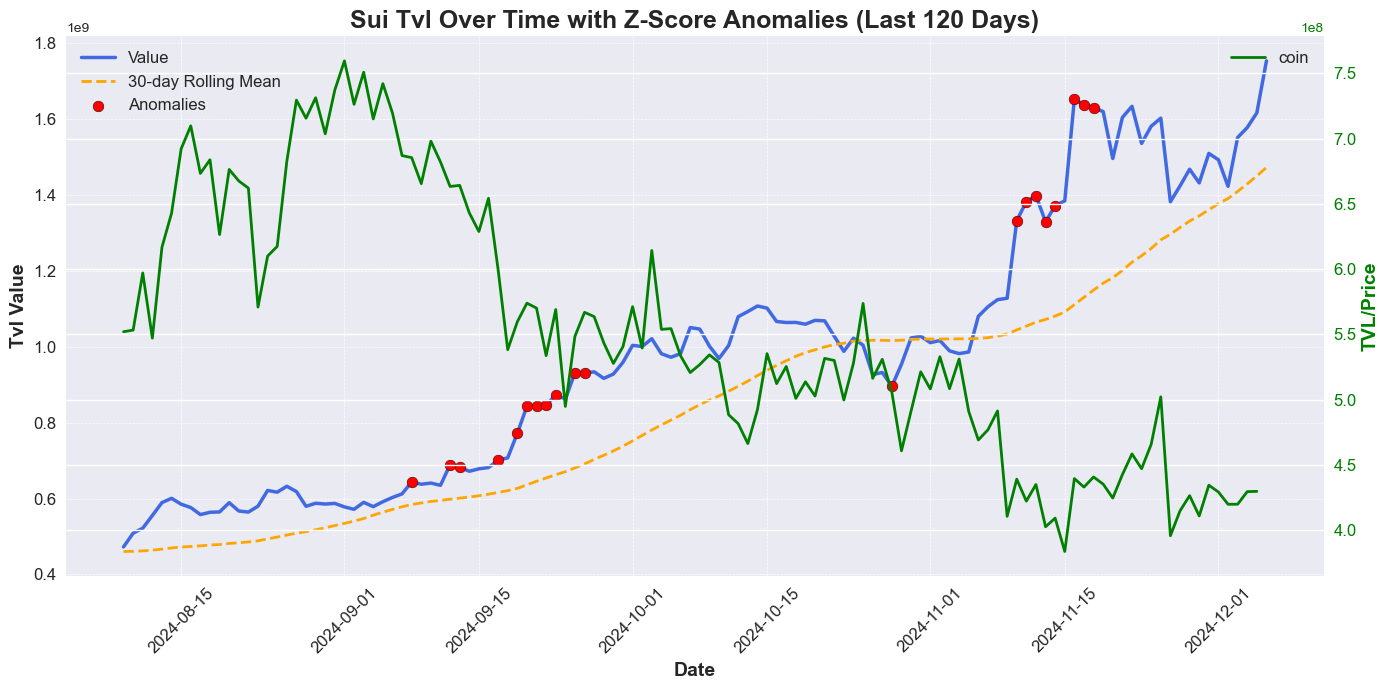

          date  tvl_price_ratio
0   2024-08-09     3.939148e+07
1   2024-08-10     3.924163e+07
2   2024-08-11     4.231873e+07
3   2024-08-12     3.920364e+07
4   2024-08-13     3.859256e+07
..         ...              ...
115 2024-12-02     2.805414e+07
116 2024-12-03     3.014537e+07
117 2024-12-04     3.062302e+07
118 2024-12-05     3.208915e+07
119 2024-12-06     2.987058e+07

[120 rows x 2 columns]
Avalanche tvl has been saved (Avalanche_tvl_coin.png)


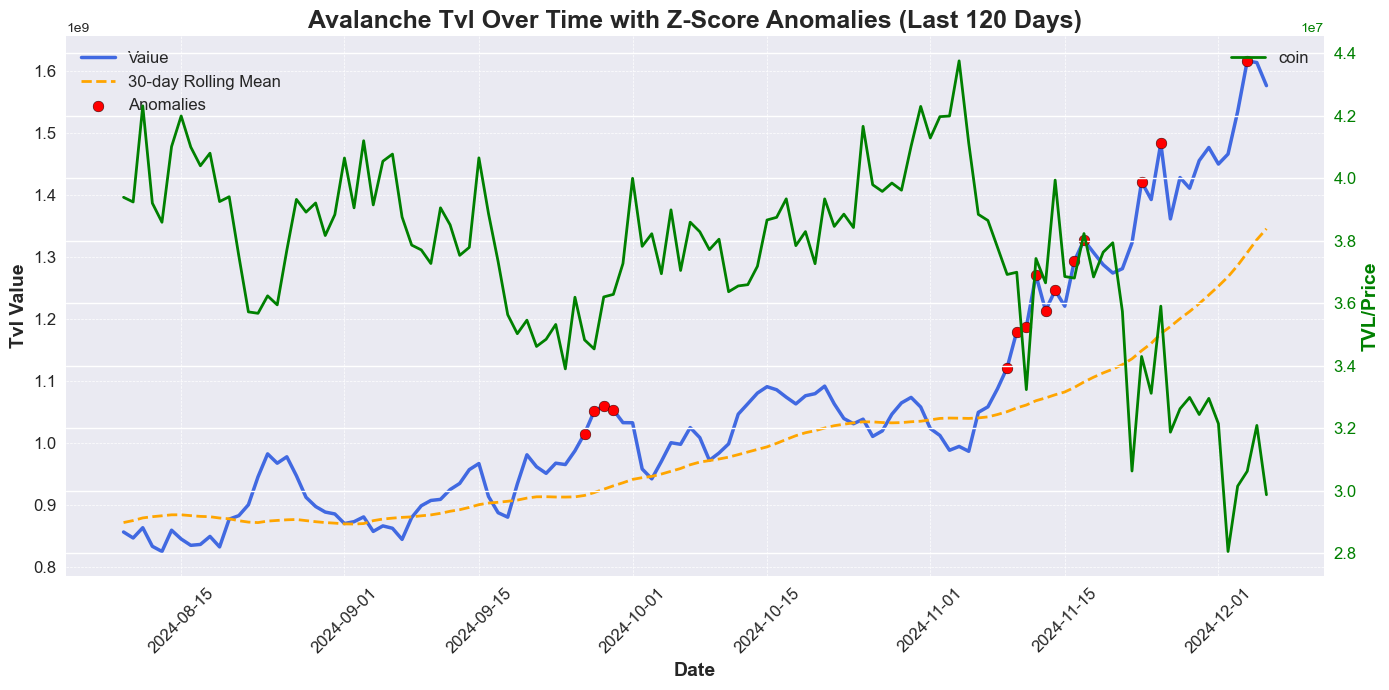

          date  tvl_price_ratio
0   2024-08-09     6.068391e+07
1   2024-08-10     5.701710e+07
2   2024-08-11     6.496690e+07
3   2024-08-12     5.716375e+07
4   2024-08-13     5.457295e+07
..         ...              ...
115 2024-12-02     8.371403e+07
116 2024-12-03     8.548542e+07
117 2024-12-04     9.016914e+07
118 2024-12-05     9.324631e+07
119 2024-12-06     8.776365e+07

[120 rows x 2 columns]
Aptos tvl has been saved (Aptos_tvl_coin.png)


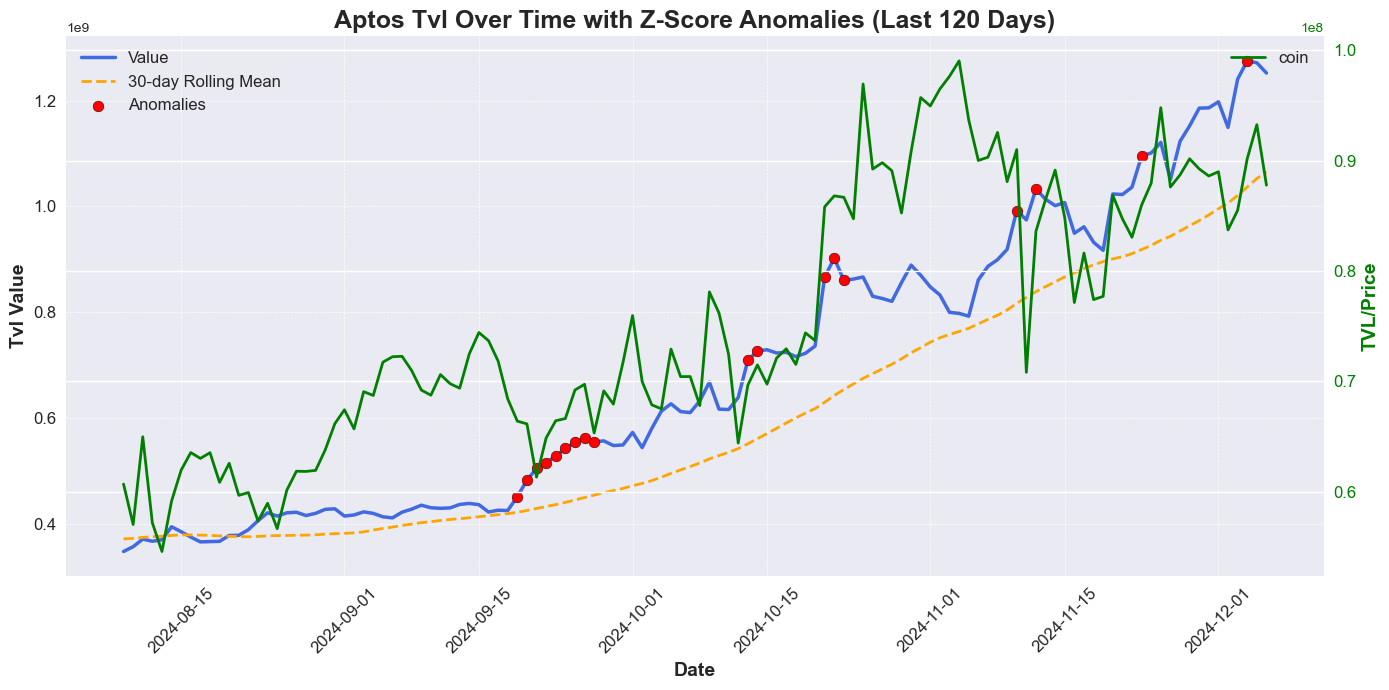

         date  tvl_price_ratio
0  2024-09-24      2809.174782
1  2024-09-25      1385.325319
2  2024-09-26      1023.984356
3  2024-09-27       970.855324
4  2024-09-28       943.223317
..        ...              ...
69 2024-12-02        68.283080
70 2024-12-03        64.671934
71 2024-12-04        73.285843
72 2024-12-05        80.694087
73 2024-12-06        80.314759

[74 rows x 2 columns]
Polygon tvl has been saved (Polygon_tvl_coin.png)


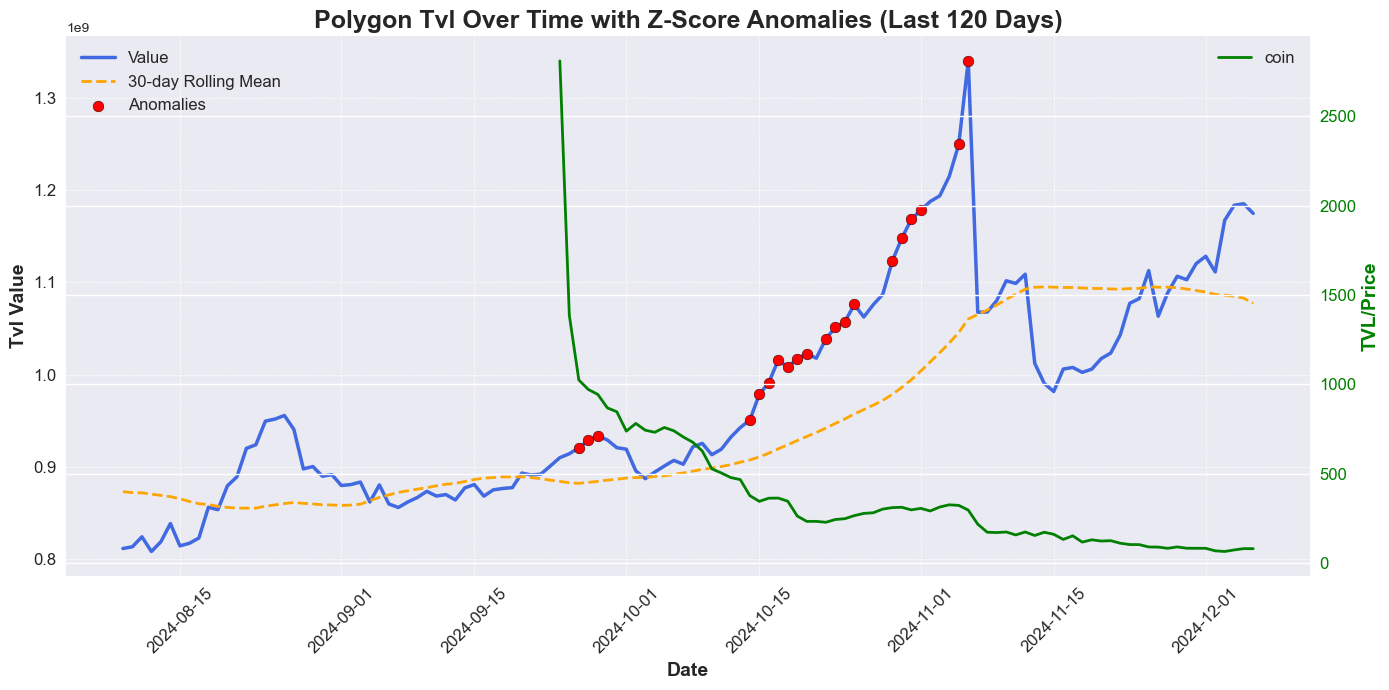

In [56]:

data_folder = 'data'
subfolders = ['fee', 'tvl', 'volume', 'price']

data_dict = {} # this one is for the last 120 days
data_dict_all = {} # this one is for all data, cuz we need to compute z-score

# read data
for subfolder in subfolders:
    folder_path = os.path.join(data_folder, subfolder)
    if os.path.exists(folder_path):
        csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

        data_dict[subfolder] = {}
        data_dict_all[subfolder] = {}

        for csv_file in csv_files:
            chain_name = csv_file.split('_')[1]

            csv_path = os.path.join(folder_path, csv_file)
            df = pd.read_csv(csv_path)

            df.columns = ['date', 'value'] if subfolder == 'fee' else ['date', subfolder]
            df.rename(columns={subfolder: 'value'}, inplace=True)
            df['date'] = pd.to_datetime(df['date'])

            data_dict[subfolder][chain_name] = df.tail(120)
            data_dict_all[subfolder][chain_name] = df

# plot_chains(data_dict['tvl'], 'tvl', mode='combined')
# plot_chains(data_dict['fee'], 'fee', mode='combined')
# plot_chains(data_dict['volume'], 'volume', mode='combined')

selected_chain = 'Ethereum'
# plot_chains(data_dict['fee'], 'fee', mode='single', selected_chain=selected_chain)
# plot_chain_zscore(data_dict_all, chain_name='Ethereum', metric='tvl', include_price=True)

for name in name_list['name']:
    if name == 'Base':
        continue
    # plot_chain_zscore(data_dict_all, chain_name=name, metric='tvl', include_price=True)
    # plot_chain_zscore(data_dict_all, chain_name=name, metric='fee', include_price=True)
    # plot_chain_zscore(data_dict_all, chain_name=name, metric='volume', include_price=True)
    plot_chain_with_coin(data_dict_all, chain_name=name, metric='tvl', include_price=True)

